In [27]:
import pandas as pd
import matplotlib.pyplot as plt

CALCULATE AVERAGE TIME SPENT ON EACH STEP OF THE PROCESS

In [28]:
# Load your CSV or paste raw data
df = pd.read_csv("/Users/jon/Desktop/Ironhack/Unit 4 - Statistics & Probability/Project-Statistics/Databases/cleaned/df_cleaned_merged_web_data_pt.txt", parse_dates=["date_time"])

# Sort actions per visit chronologically
df = df.sort_values(by=["visit_id", "date_time"])

# Shift next step timestamp within the same visit
df["next_time"] = df.groupby("visit_id")["date_time"].shift(-1)

# Calculate time spent at each step (in seconds)
df["time_spent"] = (df["next_time"] - df["date_time"]).dt.total_seconds()

# Drop last step per visit (no next_time available)
df_valid = df.dropna(subset=["time_spent"])

# Calculate average time spent per process_step
avg_time_per_step = df_valid.groupby("process_step")["time_spent"].mean().sort_values(ascending=False)

print("Average time per step (in seconds):")
print(avg_time_per_step)


Average time per step (in seconds):
process_step
confirm    256.857314
step_3     132.116471
step_2      92.450280
step_1      60.524441
start       58.696367
Name: time_spent, dtype: float64


CALCULATE FUNNELS

In [29]:
# Sort actions chronologically per visit
df = df.sort_values(by=["visit_id", "date_time"])

# Remove duplicate steps per visit (to avoid loops/skips being counted multiple times)
df_unique_steps = df.drop_duplicates(subset=["visit_id", "process_step"])

# Define the correct step order for the funnel
step_order = ["start", "step_1", "step_2", "step_3", "confirm"]

# Count how many unique visits reached each step
step_counts = df_unique_steps.groupby("process_step")["visit_id"].nunique().reindex(step_order, fill_value=0)

# Calculate funnel conversion from the first step
funnel = step_counts.to_frame(name="num_visits")
funnel["conversion_rate"] = funnel["num_visits"] / funnel["num_visits"].iloc[0] * 100  # % from start

# Display results
print("Funnel Conversion (% of users from 'start'):\n")
print(funnel)

Funnel Conversion (% of users from 'start'):

              num_visits  conversion_rate
process_step                             
start             144902       100.000000
step_1            119255        82.300451
step_2            104341        72.007978
step_3             95093        65.625733
confirm            89826        61.990863


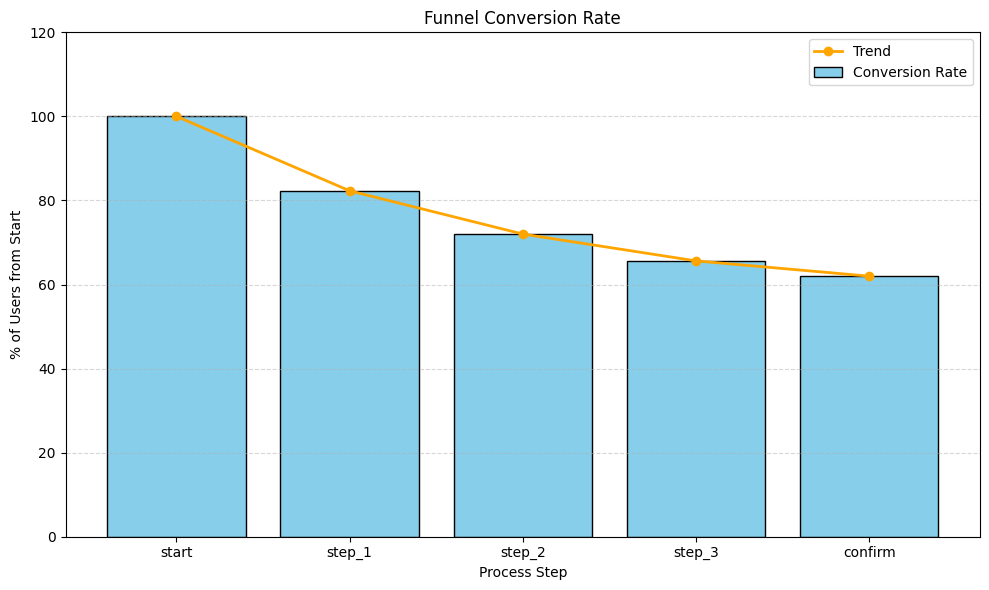

In [30]:
# Data
steps = funnel.index.tolist()
conversion_rate = funnel["conversion_rate"].tolist()

# Create plot
plt.figure(figsize=(10, 6))

# Bar chart
plt.bar(steps, conversion_rate, color="skyblue", edgecolor="black", label="Conversion Rate")

# Trend line
plt.plot(steps, conversion_rate, color="orange", marker="o", linewidth=2, label="Trend")

# Labels and styling
plt.title("Funnel Conversion Rate")
plt.ylabel("% of Users from Start")
plt.xlabel("Process Step")
plt.ylim(0, 120)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Avg Timing per Step, Fastest Group, and Significance

In [31]:
from scipy.stats import ttest_ind
import numpy as np

In [32]:
# Step 1: Merge and Calculate Time Spent by Step

In [33]:
# Load the web steps data with date_time parsed as datetime
df_web = pd.read_csv(
    "/Users/jon/Desktop/Ironhack/Unit 4 - Statistics & Probability/Project-Statistics/Databases/cleaned/df_cleaned_merged_web_data_pt.txt",
    parse_dates=["date_time"]
)

# Load the experiment clients data
df_exp = pd.read_csv(
    "/Users/jon/Desktop/Ironhack/Unit 4 - Statistics & Probability/Project-Statistics/Databases/cleaned/df_cleaned_experiment_clients_data.txt"
)

In [34]:
# Merge experiment variation info into web steps data
df = df_web.merge(df_exp, on="client_id", how="inner")

# Sort by visit_id and date_time to ensure correct order
df = df.sort_values(by=["visit_id", "date_time"])

# Calculate next timestamp per visit (for duration calculation)
df["next_time"] = df.groupby("visit_id")["date_time"].shift(-1)

# Calculate time spent in seconds on each step
df["time_spent"] = (df["next_time"] - df["date_time"]).dt.total_seconds()

# Remove rows where next_time is null (last step in visit)
df_valid = df.dropna(subset=["time_spent"]).copy()

# Optional: show first rows for verification
print(df_valid.head())


        client_id             visitor_id                      visit_id  \
106863    3561384   451664975_1722933822  100012776_37918976071_457913   
236564    7338123  612065484_94198474375   100019538_17884295066_43909   
236563    7338123  612065484_94198474375   100019538_17884295066_43909   
236562    7338123  612065484_94198474375   100019538_17884295066_43909   
236561    7338123  612065484_94198474375   100019538_17884295066_43909   

       process_step           date_time Variation           next_time  \
106863      confirm 2017-04-26 13:22:17      Test 2017-04-26 13:23:09   
236564        start 2017-04-09 16:20:56      Test 2017-04-09 16:21:12   
236563       step_1 2017-04-09 16:21:12      Test 2017-04-09 16:21:21   
236562       step_2 2017-04-09 16:21:21      Test 2017-04-09 16:21:35   
236561       step_1 2017-04-09 16:21:35      Test 2017-04-09 16:21:41   

        time_spent  
106863        52.0  
236564        16.0  
236563         9.0  
236562        14.0  
236561     

Step 2: Average Timings + T-tests per Step & Variation

In [35]:
# Group by step and variation to calculate mean and count
grouped = df_valid.groupby(["process_step", "Variation"])["time_spent"]
avg_time = grouped.mean().unstack()       # avg time per step per group
counts = grouped.count().unstack()        # counts per step per group

# List of unique process steps
steps = df_valid["process_step"].unique()

# Prepare results list
results = []

for step in steps:
    # Extract time_spent for Test and Control groups for this step
    test_times = df_valid[(df_valid["process_step"] == step) & (df_valid["Variation"] == "Test")]["time_spent"]
    control_times = df_valid[(df_valid["process_step"] == step) & (df_valid["Variation"] == "Control")]["time_spent"]
    
    # Perform t-test if we have enough data (>1 in each group)
    if len(test_times) > 1 and len(control_times) > 1:
        stat, pval = ttest_ind(test_times, control_times, equal_var=False)  # Welch's t-test
    else:
        pval = np.nan  # Not enough data
    
    # Identify faster group
    faster_group = None
    if step in avg_time.index:
        if avg_time.loc[step, "Test"] < avg_time.loc[step, "Control"]:
            faster_group = "Test"
        elif avg_time.loc[step, "Control"] < avg_time.loc[step, "Test"]:
            faster_group = "Control"
    
    results.append({
        "process_step": step,
        "avg_time_test": avg_time.loc[step, "Test"] if "Test" in avg_time.columns else np.nan,
        "avg_time_control": avg_time.loc[step, "Control"] if "Control" in avg_time.columns else np.nan,
        "test_n": counts.loc[step, "Test"] if "Test" in counts.columns else 0,
        "control_n": counts.loc[step, "Control"] if "Control" in counts.columns else 0,
        "faster_group": faster_group,
        "p_value": pval
    })

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Optional: sort steps in natural order if you want
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
results_df["step_order"] = results_df["process_step"].apply(lambda x: step_order.index(x) if x in step_order else 99)
results_df = results_df.sort_values("step_order").drop(columns="step_order")
results_df["significant"] = results_df["p_value"].apply(lambda p: "Yes" if p < 0.05 else "No")

# Show results
print(results_df)

  process_step  avg_time_test  avg_time_control  test_n  control_n  \
1        start      60.538552         62.886243   47028      37967   
2       step_1      60.580786         50.294342   35631      26177   
3       step_2      88.612506         91.617708   29665      24429   
4       step_3     128.924433        135.463130   24111      20545   
0      confirm     243.120249        164.066063    4341       2210   

  faster_group       p_value significant  
1         Test  1.764688e-01          No  
2      Control  2.719454e-17         Yes  
3         Test  3.143453e-02         Yes  
4         Test  1.519444e-03         Yes  
0      Control  2.140596e-12         Yes  


In [36]:
# Sum time_spent per visit and variation
total_time_per_visit = df_valid.groupby(["visit_id", "Variation"])["time_spent"].sum().reset_index()

# Average total time per group
avg_total_time = total_time_per_visit.groupby("Variation")["time_spent"].mean()

# Counts per group (number of visits)
counts = total_time_per_visit["Variation"].value_counts()

# Extract total times per group for t-test
test_times = total_time_per_visit[total_time_per_visit["Variation"] == "Test"]["time_spent"]
control_times = total_time_per_visit[total_time_per_visit["Variation"] == "Control"]["time_spent"]

# Run Welch's t-test
stat, p_value = ttest_ind(test_times, control_times, equal_var=False)

# Determine faster group
if avg_total_time.get("Test", np.nan) < avg_total_time.get("Control", np.nan):
    faster_group = "Test"
else:
    faster_group = "Control"

# Create a summary DataFrame with the same style as your example
summary_total_time = pd.DataFrame({
    "process_step": ["total_time"],
    "avg_time_test": [avg_total_time.get("Test", np.nan)],
    "avg_time_control": [avg_total_time.get("Control", np.nan)],
    "test_n": [counts.get("Test", 0)],
    "control_n": [counts.get("Control", 0)],
    "faster_group": [faster_group],
    "p_value": [p_value],
    "significant": ["Yes" if p_value < 0.05 else "No"]
})

print(summary_total_time)

  process_step  avg_time_test  avg_time_control  test_n  control_n  \
0   total_time     374.401276        337.855013   31512      26899   

  faster_group       p_value significant  
0      Control  1.464318e-13         Yes  
